In [1]:
import pyspark
from pyspark.sql.functions import *
from pyspark.sql import SparkSession 
from pyspark.conf import SparkConf
from pyspark.context import SparkContext
import matplotlib.pyplot as plt
conf = SparkConf().setAppName("DataVisualization").setMaster("local")
sc = SparkSession.builder.config("spark.driver.host", "localhost").getOrCreate()
#.config ("spark.sql.execution.arrow.enabled", "true").getOrCreate()
#.config ("spark.sql.shuffle.partitions", "50") \
#.config("spark.driver.maxResultSize","5g") \


# Read Credit Card Info from DB to a Data Frame
df_credit=sc.read.format("jdbc").options(driver="com.mysql.cj.jdbc.Driver",\
                                     user="root",\
                                     password="lakshmi",\
                                     url="jdbc:mysql://localhost:3306/creditcard_capstone",\
                                     dbtable="creditcard_capstone.CDW_SAPP_CREDIT_CARD").load()

# Read Branch Info from DB to a Data Frame
df_branch=sc.read.format("jdbc").options(driver="com.mysql.cj.jdbc.Driver",\
                                     user="root",\
                                     password="lakshmi",\
                                     url="jdbc:mysql://localhost:3306/creditcard_capstone",\
                                     dbtable="creditcard_capstone.CDW_SAPP_BRANCH").load()

# Read Customer Info from DB to a Data Frame
df_cust=sc.read.format("jdbc").options(driver="com.mysql.cj.jdbc.Driver",\
                                     user="root",\
                                     password="lakshmi",\
                                     url="jdbc:mysql://localhost:3306/creditcard_capstone",\
                                     dbtable="creditcard_capstone.CDW_SAPP_CUSTOMER").load()


Find and plot transactions, showing which transaction type occurs most often.

<AxesSubplot:xlabel='TRANSACTION_TYPE'>

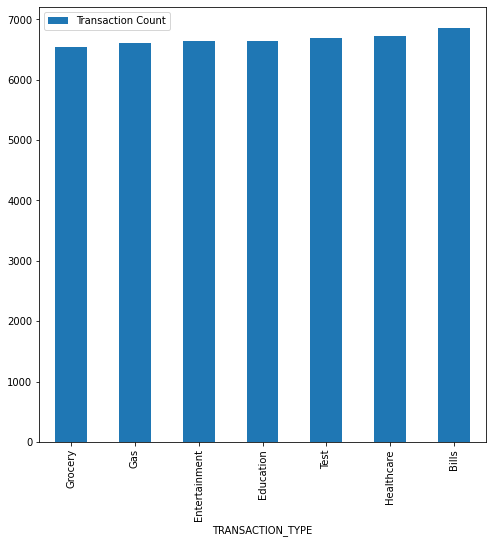

In [2]:

df_credit_pd = df_credit.groupBy('TRANSACTION_TYPE') \
        .agg(count('TRANSACTION_ID').alias('Transaction Count'), \
            (sum('TRANSACTION_VALUE')).alias('Total Transaction Value') ) \
        .sort('Transaction Count') \
        .toPandas()

df_credit_pd.plot.bar(x='TRANSACTION_TYPE', y='Transaction Count', figsize=(8, 8))


Find and plot states, showing which state has the highest number of customers.

+----------+-------------+
|CUST_STATE|CustomerCount|
+----------+-------------+
|        NY|           96|
|        GA|           73|
|        PA|           72|
|        FL|           64|
|        IL|           58|
|        NJ|           53|
|        MD|           50|
|        CA|           45|
|        MI|           44|
|        OH|           44|
|        VA|           39|
|        NC|           37|
|        TX|           33|
|        MA|           33|
|        SC|           30|
|        WI|           29|
|        MN|           28|
|        MS|           24|
|        IA|           21|
|        KY|           17|
+----------+-------------+
only showing top 20 rows



<AxesSubplot:xlabel='CUST_STATE', ylabel='Customer Count'>

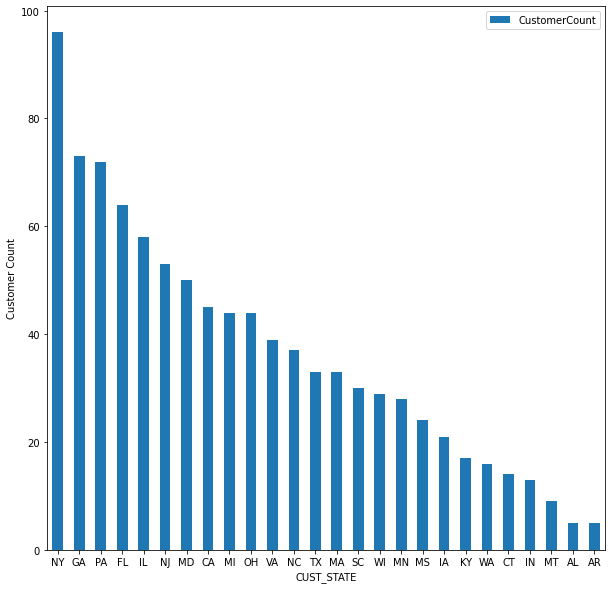

In [3]:
df_cust.groupBy('CUST_STATE') \
        .agg(count('SSN').alias('CustomerCount')) \
        .orderBy('CustomerCount', ascending=False).show()

df_cust_pd = df_cust.groupBy('CUST_STATE') \
        .agg(count('SSN').alias('CustomerCount')) \
        .orderBy('CustomerCount', ascending=False).toPandas()

df_cust_pd.plot.bar(x='CUST_STATE', y='CustomerCount' , ylabel = 'Customer Count',rot=0, figsize=(10, 10) )


Find and plot the sum of all transactions for each customer, and which customer has the highest transaction amount. (First 20)
hint(use CUST_SSN).

In [4]:
df_credit.join(df_cust, df_credit.CUST_SSN == df_cust.SSN, 'inner'). \
    groupBy('FIRST_NAME', 'LAST_NAME') \
        .agg(sum('TRANSACTION_VALUE').alias('Total Transaction Value'))  \
        .orderBy('Total Transaction Value', ascending=False).limit(20).show()


+----------+----------+-----------------------+
|FIRST_NAME| LAST_NAME|Total Transaction Value|
+----------+----------+-----------------------+
|        Ty|      Daly|     5633.0700000000015|
|    Jessie|   Boucher|      5548.140000000001|
|    Phoebe|    Martin|      5476.079999999999|
|   Thurman|      Vera|      5314.970000000003|
|      Bret|   Perkins|      5261.030000000001|
|    Joesph|   Mcclain|                5241.18|
|   Aurelia|      Haas|      5223.959999999999|
|   Marcelo|   Emerson|      5203.080000000001|
|    Alexis|Villarreal|                5149.75|
| Christina|      Snow|      5133.290000000002|
|   Whitney|     Boggs|      5062.330000000003|
|       Bud|     Boyce|     5046.0700000000015|
|    Carrol|     Lynch|      5023.650000000001|
|    Lorrie| Whitfield|      5014.010000000003|
|   Liliana|    Dunham|     5012.8099999999995|
|       Pam|     Moore|      5008.230000000001|
|    Bertha|     Bunch|      5008.089999999998|
|     Adele|     Arias|                5

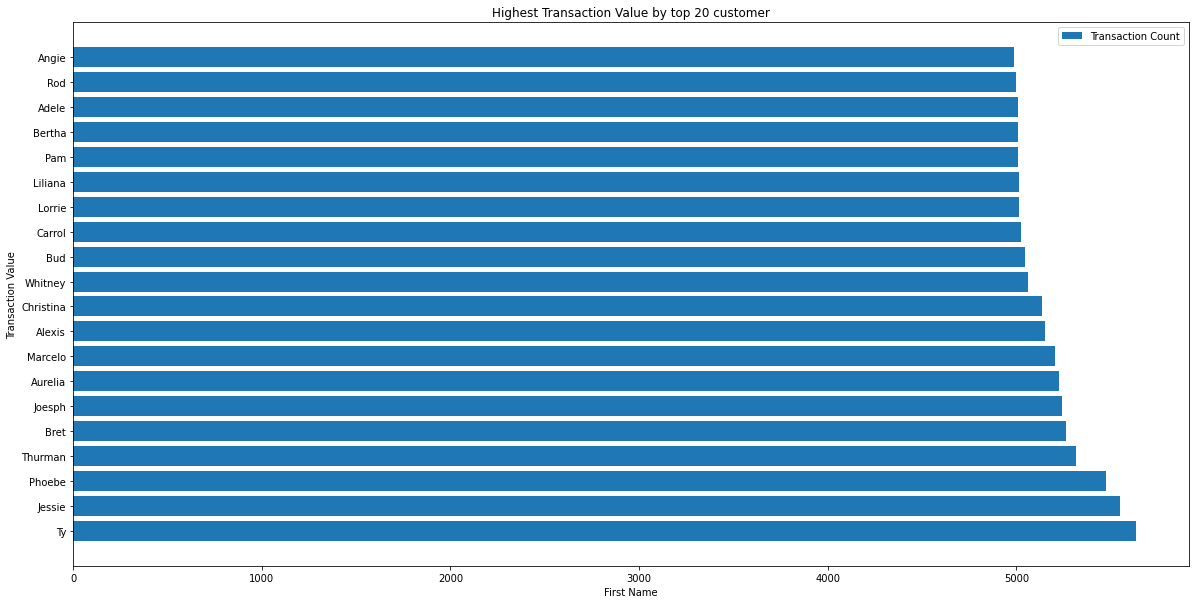

In [5]:
from matplotlib.pyplot import figure
df_cust_credit_pd = df_credit.join(df_cust, df_credit.CUST_SSN == df_cust.SSN, 'inner'). \
    groupBy('CUST_SSN', 'FIRST_NAME') \
        .agg(sum('TRANSACTION_VALUE').alias('Total Transaction Value'))  \
        .orderBy('Total Transaction Value', ascending=False).limit(20).toPandas()
plt.figure(figsize=(20, 10))

plt.barh(df_cust_credit_pd['FIRST_NAME'], df_cust_credit_pd['Total Transaction Value'])
plt.ylabel("Transaction Value")
plt.xlabel("First Name")
plt.legend(['Transaction Count'])
plt.title("Highest Transaction Value by top 20 customer")

plt.show()


#ax_bar = df_cust_credit_pd.plot.bar(x='FIRST_NAME', y='Total Transaction Value', ylabel = 'TRANSACTION_VALUE', figsize=(20, 10) )    


Find and plot the top three months with the largest transaction data

In [20]:
df_credit = df_credit.withColumn("TransactionMonth", substring(df_credit.TIMEID,5,2))
df_credit.groupBy('TransactionMonth') \
        .agg(count('TRANSACTION_ID').alias('Transaction Count'), \
            (sum('TRANSACTION_VALUE')).alias('Total Transaction Value') ) \
        .orderBy('Transaction Count', ascending=False).limit(3) \
        .show()

+----------------+-----------------+-----------------------+
|TransactionMonth|Transaction Count|Total Transaction Value|
+----------------+-----------------+-----------------------+
|              02|             3959|     201086.67000000033|
|              05|             3946|     201310.26000000033|
|              10|             3946|      202583.8899999999|
+----------------+-----------------+-----------------------+



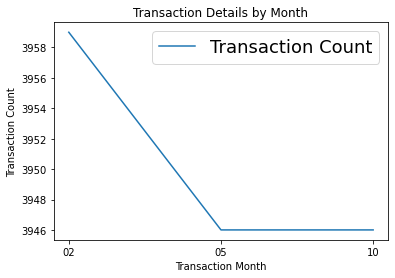

In [21]:
import pyspark.sql.functions as f
df_credit_pd_2 = df_credit.groupBy('TransactionMonth') \
        .agg(count('TRANSACTION_ID').alias('Transaction Count'), \
            (sum('TRANSACTION_VALUE')).alias('Total Transaction Value') ) \
        .orderBy('Transaction Count', ascending=False) \
        .limit(3).toPandas()
plt.plot(df_credit_pd_2['TransactionMonth'], df_credit_pd_2['Transaction Count'])
plt.ylabel("Transaction Count")
plt.xlabel("Transaction Month")
plt.legend(['Transaction Count'], fontsize=18)
plt.title("Transaction Details by Month")
plt.show()
#plt.plot(df_credit_pd_2['TransactionMonth'], df_credit_pd_2['Transaction Count'], ylabel = 'Transaction Count', rot=0, figsize=(10, 10) )    

<AxesSubplot:ylabel='BRANCH_CITY'>

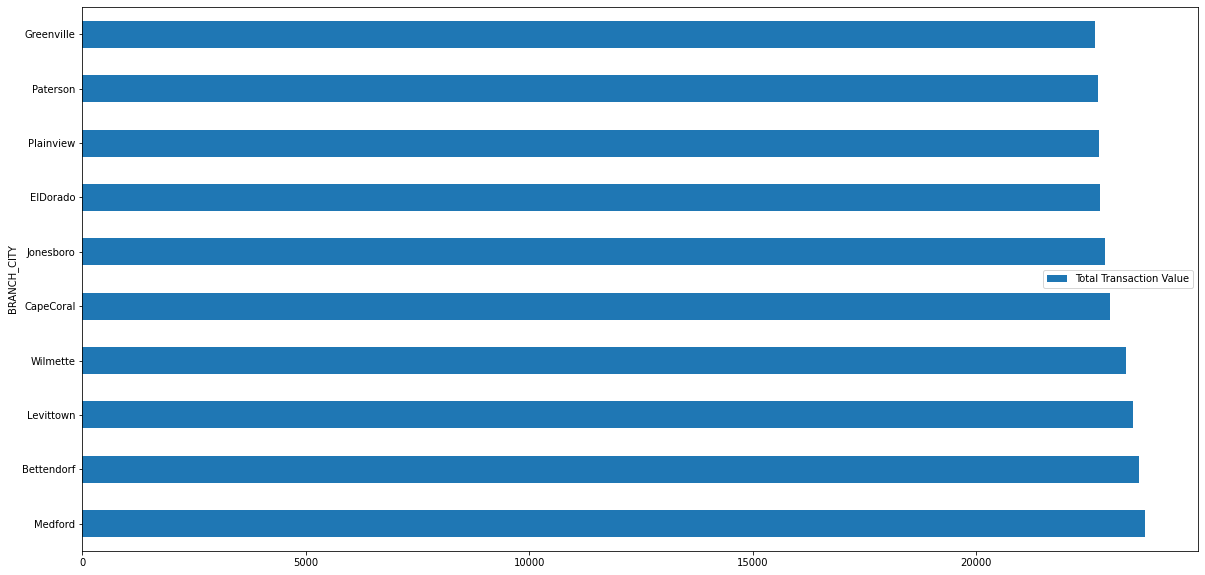

In [22]:
df_branch_credit_pd = df_credit.join(df_branch, df_credit.BRANCH_CODE == df_branch.BRANCH_CODE, 'inner') \
        .groupBy('BRANCH_CITY') \
        .agg(sum('TRANSACTION_VALUE').alias('Total Transaction Value')) \
        .orderBy('Total Transaction Value', ascending=False).limit(10) \
        .toPandas()

df_branch_credit_pd.plot.barh(x='BRANCH_CITY', y='Total Transaction Value' , rot=0, figsize=(20, 10) )    
